In [51]:
import numpy as np
from orphics import cosmology
import matplotlib.pyplot as plt
from pixell import powspec

%matplotlib inline

### orphics library
https://github.com/msyriac/orphics/blob/master/orphics/cosmology.py#L1124
### pixell library
https://github.com/simonsobs/pixell

In [52]:

lmax = 30000

cmbhd_exp = { #beam and noise level
    30: (1.25, 6.4),
    40: (0.94, 3.4),
    90: (0.42, 0.7),
    150: (0.25, 0.8),
    220: (0.17, 2),
    280: (0.13, 2.7),
    350: (0.11, 100)
}

def white_noise_with_atm_func(ell,uk_arcmin,lknee,alpha,dimensionless,TCMB=2.7255e6):
    atmFactor = atm_factor(ell,lknee,alpha)
    noiseWhite = ell*0.+(uk_arcmin*np.pi / (180. * 60))**2.
    dfact = (1./TCMB**2.) if dimensionless else 1.
    return (atmFactor+1.)*noiseWhite*dfact

def gauss_beam(ells,fwhm):
    tht_fwhm = np.deg2rad(fwhm / 60.)
    return np.exp(-(tht_fwhm**2.)*(ells**2.) / (16.*np.log(2.)))

## compute noise curve

l = np.arange(lmax+1)
Nls = {"l": l }
for freq_idx in [90, 150]:
    idx = "f{}".format(freq_idx)

    fwhm, noise_level = cmbhd_exp[freq_idx]
    print(noise_level, fwhm)
    Nt = cosmology.white_noise_with_atm_func(l, noise_level, 0, 0, False)
    f_beam = gauss_beam(l,fwhm)
    Nls[idx] = Nt/f_beam**2 ### note that we deconvolved the beamßß

Weights = {"l": l}

## coadding noise
W_150 = 1/Nls["f150"]
W_90 = 1/Nls["f90"]
W_tot = W_150+W_90

W_150 = W_150/W_tot
W_90 = W_90/W_tot
Weights["f150"] = W_150
Weights["f90"] = W_90
Nls["coadded"] = Weights["f150"].copy()**2*Nls["f150"].copy()+Weights["f90"].copy()**2*Nls["f90"].copy()

## load precomputed txt as reference
saved = {}
saved["f150"] = np.loadtxt("data/cmbhd_white_noise_cls_f150.txt")
saved["f90"] = np.loadtxt("data/cmbhd_white_noise_cls_f90.txt")

## CMB Theory
cmb_theo = powspec.read_spectrum("data/planck2018_30000_lensedCls.dat")

0.7 0.42
0.8 0.25


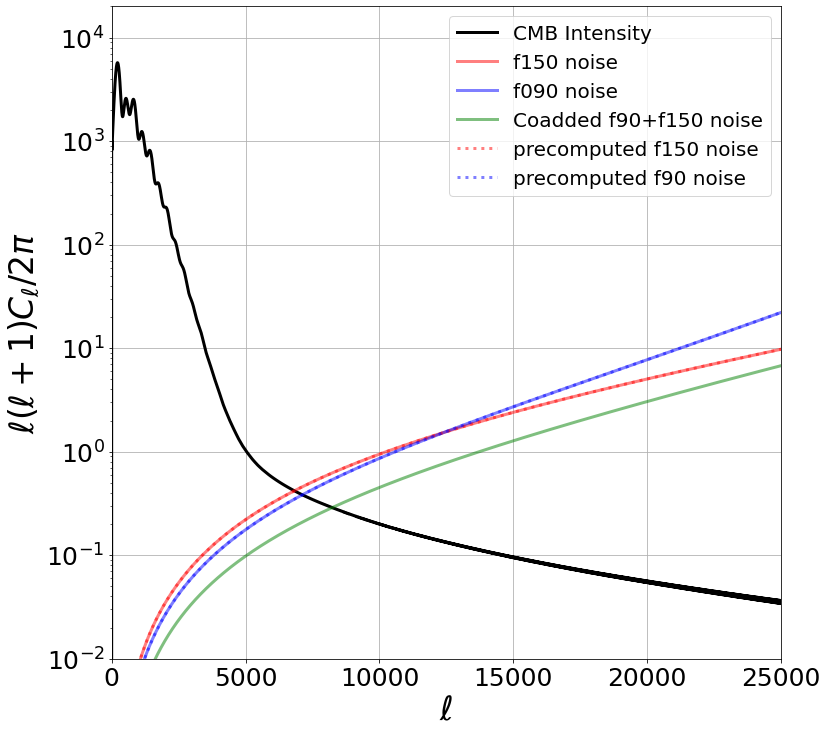

In [60]:
l_fact = l*(l+1)/(2*np.pi)
fig = plt.figure(figsize=(12,12))
ax = plt.gca()

plt.plot(l, l_fact*cmb_theo[0,0], color="k", alpha=1, lw=3, ls="-", label="CMB Intensity")
plt.plot(l, l_fact*Nls["f150"], color="r", alpha=0.5, lw=3, label="f150 noise")
plt.plot(l, l_fact*Nls["f90"], color="b", alpha=0.5, lw=3, label="f090 noise")
plt.plot(l, l_fact*Nls["coadded"], color="g", alpha=0.5, lw=3, label=f"Coadded f90+f150 noise")
plt.plot(l, l_fact*saved["f150"][:,1], color="r", ls=":", alpha=0.5, lw=3, label="precomputed f150 noise")
plt.plot(l, l_fact*saved["f90"][:,1], color="b", ls=":", alpha=0.5, lw=3, label="precomputed f90 noise")
ax.set_ylim((1e-2, 2e4))
ax.set_xlim((0, 25000))
ax.set_yscale("log")
plt.tick_params(axis='both', which='major', labelsize=25)
ax.set_ylabel(r"$\ell(\ell+1)C_\ell/2\pi$", {"fontsize":33})
plt.grid(True)

plt.legend(fontsize=20, loc="upper right")    
ax.set_xlabel(r"$\ell$", {"fontsize":33})
plt.show()